In [1]:
from gensim.models import word2vec
import MeCab
import numpy as np
import json
import hashlib
from sklearn.cross_decomposition import CCA
from googletrans import Translator

In [2]:
translator = Translator()
model = word2vec.Word2Vec.load("wiki_plus.model")
mt = MeCab.Tagger('-d /usr/local/lib/mecab/dic/mecab-ipadic-neologd/')
mt.parse('')

'EOS\n'

In [3]:
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
model_doc = Doc2Vec.load("jawiki.doc2vec.dbow300d.model")

In [4]:
def get_tags_for_doc2vec(text):
    word = []
    node = mt.parseToNode(text)
    while node:
        fields = node.feature.split(",")
        if node.surface in model_doc.wv:
            w = node.surface
            word.append(w)
        node = node.next
    return word

In [5]:
def get_tags(text):
    word = {}
    node = mt.parseToNode(text)
    while node:
        fields = node.feature.split(",")
        # 名詞、動詞、形容詞のいずれか、かつ、w2vに登録されている単語だけ
        if (fields[0] == '名詞' or fields[0] == '動詞' or fields[0] == '形容詞') and node.surface in model.wv:
#        if (fields[0] == '名詞' or fields[0] == '形容詞') and node.surface in model.wv:
            w = node.surface
            word[w] = word.get(w, 0) + 1
        node = node.next
    return word

In [6]:
class Event:
    def __init__(self, id, type, score, desc, links):
        self.id = id
        self.type = type
        self.score = score
        self.desc = desc
        self.tags = get_tags(desc)
        self.links = links
    
    def __str__(self):
        return 'id: {id} type: {type} score: {score} tags: {tags}'.format(id=self.id, type=self.type, score=self.score, tags=str(self.tags))

    def __repr__(self):
        return 'id: {id} type: {type} score: {score} tags: {tags}'.format(id=self.id, type=self.type, score=self.score, tags=str(self.tags))

In [7]:
class Event_doc2vec(Event):
    def __init__(self, id, type, score, desc, links):
        super().__init__(id,type,score,desc,links)
        self.tags = get_tags_for_doc2vec(desc)

In [8]:
# JSON ファイルから event set をロード
def load_events(jsonfile):
    with open(jsonfile) as f:
        df = json.load(f)
    events = {x['id']: Event(x['id'], x['type'], x['score'], x['desc'], x['links']) for x in df} #eventsにidをkeyとしそのオブジェクトをvalueとした辞書を生成
    for k,x in events.items():
        x.links = [events[e] for e in x.links] #Event.linkの中身をidの配列からEventの配列に変更
    return events

In [9]:
# JSON ファイルから event set をロード ver.doc2vec
def load_events_for_doc2vec(jsonfile):
    with open(jsonfile) as f:
        df = json.load(f)
    events = {x['id']: Event_doc2vec(x['id'], x['type'], x['score'], x['desc'], x['links']) for x in df} #eventsにidをkeyとしそのオブジェクトをvalueとした辞書を生成
    for k,x in events.items():
        x.links = [events[e] for e in x.links] #Event.linkの中身をidの配列からEventの配列に変更
    return events

In [10]:
events = load_events('sesaku2.json')
events_doc2vec = load_events_for_doc2vec('sesaku2.json')

# 類似度

In [11]:
# cos similality
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)) #ベクトルの積/（ベクトルの大きさ＊ベクトルの大きさ）

# doc vec with weighted mean
def weighted_mean_vec(e):
    v = np.zeros(model.vector_size)
    s = 1.0
    for w,weight in e.tags.items():
        v += weight * model.wv[w]  #Eventクラスeの単語wの個数＊単語wのベクトル
        s += weight
    return v / s

# doc間のsimilality (weighted mean_vec and cos_sim)
def event_sim_cos(e1, e2):
    return cos_sim(weighted_mean_vec(e1), weighted_mean_vec(e2))

In [12]:
# CCAの相関係数によるsimilality
def get_vectors(e1):
    return np.array([model.wv[w] for w,weight in e1.tags.items()]) # Eventクラスeの単語それぞれのベクトルを要素とする配列
def event_sim_cca(e1, e2):
    x1 = get_vectors(e1)
    x2 = get_vectors(e2)
    n = min(x1.shape[0], x2.shape[0])
    assert(n >= 1)
    cca = CCA(n_components=n)
    cca.fit(x1.transpose(), x2.transpose())
    return cca.score(x1.transpose(), x2.transpose())

In [13]:
def tokenize(text):
    return mt.parse(text).strip().split()

In [14]:
#eventsはidをkeyそのidに対するeventをvalueとした辞書
def search_events_cos(keywords, events):
    e1 = Event('keywords', [], 0.0, keywords, []) #Event(id, type, score, desc, links)
    if len(e1.tags) == 0:
        raise NameError('Tag is empty')
    sims = [(x.desc, event_sim_cos(e1, x)) for k,x in events.items() if len(x.tags) >= 1]
    return sorted(sims, key=lambda x:x[1], reverse=True)[:10]

def search_events_cca(keywords, events):
    e1 = Event('keywords', [], 0.0, keywords, [])
    if len(e1.tags) == 0:
        raise NameError('Tag is empty')
    sims = [(x.desc, event_sim_cca(e1, x)) for k,x in events.items() if len(x.tags) >= 1]
    return sorted(sims, key=lambda x:x[1], reverse=True)[:10]

In [15]:
#['都道府県']と['keyword']の類似度
def search_events_doc2vec1(keywords,events):
    e1 = Event_doc2vec('keywords',[],0.0,keywords,[])
    if len(e1.tags) == 0:
        raise NameError('Tag is empty')
    sims = [( x.desc, model_doc.docvecs.similarity_unseen_docs(model_doc, [x.id], e1.tags, alpha=1, min_alpha=0.0001, steps=5)) for k,x in events.items() if len (x.tags) >=1]
    return sorted(sims,key=lambda x:x[1], reverse=True)[:10]

In [16]:
#['都道府県']のtextと['keyword']の類似度
def search_events_doc2vec2(keywords,events):
    e1 = Event_doc2vec('keywords',[],0.0,keywords,[])
    if len(e1.tags) == 0:
        raise NameError('Tag is empty')
    
    sims = [( x.desc, model_doc.docvecs.similarity_unseen_docs(model_doc, x.tags, e1.tags, alpha=1, min_alpha=0.0001, steps=5))  for k,x in events.items() if len (x.tags) >=1]
    return sorted(sims,key=lambda x:x[1], reverse=True)[:10]

In [17]:
#infervec (cos) ['都道府県']と['keyword']の類似度
def search_events_doc2vec3(keywords,events):
    e1 = Event_doc2vec('keywords',[],0.0,keywords,[])
    if len(e1.tags) == 0:
        raise NameError('Tag is empty')
    y = model_doc.infer_vector(e1.tags)
    sims = [( x.desc,cos_sim(y,model_doc.infer_vector([x.id])))  for k,x in events.items() if len (x.tags) >=1]
    return sorted(sims,key=lambda x:x[1], reverse=True)[:10]

In [18]:
#infervec (cos) ['都道府県']のtextと['keyword']の類似度
def search_events_doc2vec4(keywords,events):
    e1 = Event_doc2vec('keywords',[],0.0,keywords,[])
    if len(e1.tags) == 0:
        raise NameError('Tag is empty')
    y = model_doc.infer_vector(e1.tags)
    sims = [( x.desc,cos_sim(y,model_doc.infer_vector(x.tags)))  for k,x in events.items() if len (x.tags) >=1]
    return sorted(sims,key=lambda x:x[1], reverse=True)[:10]

In [19]:
search_events_doc2vec1('エンジン',events_doc2vec)

[('ステアリングヨークを選定後トルク変動計算し基準値以内にする', 0.17089543),
 ('内製EMPSギヤアセンブリの搭載を検討する', 0.15039669),
 ('原価企画・原価計画・原価維持・原価改善といった視点で、原価管理を実施している。', 0.1482835),
 ('社内コストテーブルがあり、関連部門と連携しながら原価算出', 0.1431767),
 ('エンジン本体 オイルフィルター\u3000キャップアセンブリ', 0.13511296),
 ('エンジン本体 ラジエターキャップ\u3000アセンブリ', 0.13368987),
 ('足踏みパーキングとPバルブの軽量化検討', 0.1329244),
 ('組立性、メンテ性の課題項目出し', 0.13139021),
 ('必要人員と配置人員の関係を見える化', 0.13099784),
 ('社内標準は体系的に整備、定期的な見直しがされている', 0.12380567)]

In [20]:
search_events_doc2vec2('エンジン',events_doc2vec)

[('エンジン搭載 ゴム\u3000クッション', 0.64897096),
 ('エンジン本体 燃料蒸気供給パイプ', 0.6162985),
 ('エンジン搭載 ラジエターキャップ', 0.6135371),
 ('エンジン本体 吸気マニホールド\u3000ガスケット', 0.604617),
 ('エンジン本体 ファンプーリー', 0.60384923),
 ('エンジン本体 オイルレベルゲージ', 0.5946971),
 ('エンジン搭載 アイドラープーリ', 0.5925279),
 ('エンジン本体 クランクシャフトベアリング', 0.5843426),
 ('エンジン搭載 燃料ポンプ 抵抗器アセンブリ', 0.57747936),
 ('エンジン本体 燃料蒸気供給ホース', 0.5763741)]

In [21]:
search_events_doc2vec3('エンジン',events_doc2vec)

[('エンジン本体 燃料インジェクター', 0.14703085),
 ('足踏みパーキングとPバルブの軽量化検討', 0.14143185),
 ('エンジン搭載 フライホイール', 0.13866842),
 ('システムズ・エンジニアリングを導入してモデルベース開発を実施', 0.13755569),
 ('エンジン本体 ウォーターバイパス\u3000ホース', 0.13534153),
 ('必要人員と配置人員の関係を見える化', 0.13509117),
 ('PSギヤ支持率は、操舵安定性部門と確認', 0.13126369),
 ('エンジン本体 クランクシャフト', 0.12759389),
 ('油圧ラインレイアウト', 0.12564377),
 ('最新製品を使う場合、搭載性と干渉の寸法確認', 0.12524386)]

In [22]:
search_events_doc2vec4('エンジン',events_doc2vec)

[('エンジン搭載 アイドラープーリ', 0.9415362),
 ('エンジン本体 バルブスプリングシート', 0.9386966),
 ('エンジン本体 ウォーターアウトレットパイプ', 0.9372415),
 ('エンジン本体 ワッシャープレート', 0.93630713),
 ('エンジン本体 シリンダーヘッドサブアセンブリ', 0.9362935),
 ('エンジン本体 エアサージタンクガスケット', 0.93626267),
 ('エンジン本体 ウォーターインレット', 0.9352318),
 ('エンジン本体 ワッシャーボルト', 0.9341545),
 ('エンジン本体 バキュームスイッチングバルブ', 0.9340271),
 ('エンジン本体 カムシャフトサブアセンブリ', 0.9338576)]

In [23]:
search_events_cos('エンジン', events)

[('エンジン本体 カバーサブアセンブリ、エンジン', 0.9138092408021387),
 ('エンジン本体 エンジンマウント\u3000ブラケット', 0.8158224288512752),
 ('エンジン本体 シリンダーブロック', 0.7885445241380861),
 ('エンジン本体 シリンダーブロック\u3000サブアッシー', 0.7885445241380861),
 ('エンジン本体 燃料フィレットバルブ\u3000アッシー', 0.7871171653986341),
 ('エンジン本体 燃料インジェクター', 0.7838387747005583),
 ('エンジン本体 燃料インジェクタ', 0.7834878029477366),
 ('エンジン本体 スパークプラグ', 0.7834251553887912),
 ('エンジン本体 燃料フィレットバルブアセンブリ', 0.783119937549118),
 ('エンジン搭載 インレット\u3000エアクリーナー', 0.7776428586092169)]

In [24]:
search_events_cca('エンジン', events)

[('エンジン搭載 アイドラープーリ', 0.5947456051612782),
 ('エンジン本体 シリンダーヘッドサブアセンブリ', 0.5142887949212165),
 ('エンジン本体 オイルレベルゲージ', 0.5142887949212165),
 ('エンジン本体 カバーサブアセンブリ、エンジン', 0.5142887949212165),
 ('エンジン本体 カムシャフトサブアセンブリ', 0.5142887949212165),
 ('エンジン本体 コンプレッションリング', 0.5142887949212165),
 ('エンジン本体 チェーンサブアセンブリ', 0.5142887949212165),
 ('エンジン本体 チェーンバイブレーションダンパー', 0.5142887949212165),
 ('エンジン本体 アイドルギアシャフト', 0.5142887949212165),
 ('エンジン本体 バルブスプリングシート', 0.5142887949212165)]

# トレーニングデータ作り

In [25]:
number = 0
for k,v in events.items():
    if v.type[-1]=='部品':
        print(v.type,v.desc)
        number += 1

['部品'] エンジン搭載 吸気レゾネーター
['部品'] エンジン搭載 燃料ポンプ 抵抗器アセンブリ
['部品'] エンジン搭載 燃料ポンプ
['部品'] エンジン搭載 ゴム　クッション
['部品'] エンジン搭載 燃料圧力ダンパー
['部品'] エンジン搭載 燃料ポンプ　抵抗カバー
['部品'] エンジン搭載 燃料フィルター
['部品'] エンジン搭載 燃料パイプ
['部品'] エンジン搭載 燃料蒸気供給ホース
['部品'] エンジン搭載 燃料ホース　クランプ
['部品'] エンジン搭載 燃料ポンプ　絶縁体
['部品'] エンジン搭載 エアバッグラベル　DRVRパスに関する注意
['部品'] エンジン搭載 パイプ　チャコールキャニスター
['部品'] エンジン搭載 ブラケット　チャコールキャニスター
['部品'] エンジン搭載 ペダル　アクセラレータ
['部品'] エンジン搭載 フレキシブルホース
['部品'] エンジン搭載 フライホイール
['部品'] エンジン搭載 インレット　エアクリーナー
['部品'] エンジン搭載 ファン部品　モータ付き
['部品'] エンジン搭載 換気ホース
['部品'] エンジン搭載 エンジン取り付け　絶縁部品　
['部品'] エンジン搭載 エンジン取り付け　絶縁体
['部品'] エンジン搭載 ラジエターキャップ
['部品'] エンジン搭載 ラジエター　サポート
['部品'] エンジン搭載 ラジエター　ホース
['部品'] エンジン搭載 アイドラープーリ
['部品'] エンジン搭載 クリップ
['部品'] エンジン本体 Vバンクカバー　ブラケットサブアセンブリ
['部品'] エンジン本体 シリンダーヘッドサブアセンブリ
['部品'] エンジン本体 シリンダーヘッド
['部品'] エンジン本体 シリンダーヘッド　ガスケット
['部品'] エンジン本体 ブッシュ　バルブガイドインテーク
['部品'] エンジン本体 ブッシュ　バルブガイド排気
['部品'] エンジン本体 吸気バルブ　シート
['部品'] エンジン本体 エキゾーストバルブ
['部品'] エンジン本体 カムシャフトベアリング　キャップ
['部品'] エンジン本体 セミサーキュレータ　プラグ
['部品'] エンジン本体 　Vバンクカバーサブアセンブリ
['部品'] エンジン本体

In [26]:
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

/Users/wsiny/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# データ作り

In [27]:
class Label:
    TAISAKU = 1
    NASI = 0

data = []
labels = []
number = 0
# data 
for k1, v1 in events_doc2vec.items():
    if v1.type[-1]=='部品':
        for k2, v2 in events_doc2vec.items():
            if v2.type[-1] == '対策':
                x1 = model_doc.infer_vector(v1.tags)
                x2 = model_doc.infer_vector(v2.tags)
                data.extend([np.append(x1, x2)])
                if v2 in v1.links:
                    labels.append(Label.TAISAKU)
                else:
                    labels.append(Label.NASI)

In [28]:
data = np.array(data)
labels = np.array(labels)

In [29]:
print('data:',data)
print('labels:',labels)
print('labelの１の数:',labels.sum())

data: [[ 0.37849137 -0.00249377 -0.12993084 ...  0.04587793 -0.20162961
  -0.20666136]
 [ 0.41392267  0.02476834 -0.11782233 ...  0.20008853 -0.17636672
  -0.39129692]
 [ 0.41759142  0.0365326  -0.12706666 ...  0.13764629 -0.25714076
  -0.12622036]
 ...
 [ 0.3048881  -0.04506965 -0.02300045 ...  0.01170841 -0.13503624
  -0.41412035]
 [ 0.27085957 -0.04944429 -0.01557983 ... -0.03673898 -0.13248235
  -0.3479829 ]
 [ 0.27768967 -0.02736613  0.01128429 ...  0.04558801 -0.16423152
  -0.25115624]]
labels: [0 0 0 ... 0 0 0]
labelの１の数: 7324


In [30]:
print('data.shape', data.shape)
print('labels.shape', labels.shape)

data.shape (55533, 600)
labels.shape (55533,)


In [31]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

In [32]:
print('トレーニングデータの全体の数:',x_train.shape[0])
print('トレーニングデータの1の数    :',y_train.sum())
print('トレーニングデータ1の割合    :',round(y_train.sum()/x_train.shape[0]*100,1),'%')
print('テストデータの全体の数         :',x_test.shape[0])
print('テストデータの１の数            :',y_test.sum())
print('テストデータの1の割合          :',round(y_test.sum()/x_test.shape[0]*100,1),'%')

トレーニングデータの全体の数: 44426
トレーニングデータの1の数    : 5871
トレーニングデータ1の割合    : 13.2 %
テストデータの全体の数         : 11107
テストデータの１の数            : 1453
テストデータの1の割合          : 13.1 %


# 学習させる

In [33]:
# y_train を one-hot 表現にする。
y_train = np_utils.to_categorical(y_train)

# モデルを作成する。
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=600)) #activation
model.add(Dense(100, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(
    optimizer='adam', #最適化アルゴリズムの種類.sgd,rmsprop,adam,adagrad,nadam,adadeltaなどある。
    loss='categorical_crossentropy', #損失関数名
    metrics=['accuracy']) #訓練やテストの際にモデルを評価するための評価関数のリスト． 典型的には metrics=['accuracy']を使用する.

# 学習を実行する。
model.fit(x_train, y_train, batch_size=16, epochs=30) #epochs 学習回数,batch_size 重みを調整の際に行う平均化のときに使うデータの数（dataの数/batch_size回）×epochs

# モデルを保存する。
model.save('model.h5')

# 推論する。
prob = model.predict(x_test, batch_size=len(x_test))

# 最も確率が高いのを推定クラスとする。
y_pred = np.argmax(prob, axis=1)

# 精度を検証する。
accuracy = accuracy_score(y_test, y_pred)
print('accuracy: {:.2%}'.format(accuracy))  # accuracy: 100.00%

Epoch 1/30
2777/2777 [==============================] - 2s 619us/step - loss: 0.1828 - accuracy: 0.9325
Epoch 2/30
2777/2777 [==============================] - 2s 614us/step - loss: 0.0933 - accuracy: 0.9627
Epoch 3/30
2777/2777 [==============================] - 2s 607us/step - loss: 0.0717 - accuracy: 0.9722
Epoch 4/30
2777/2777 [==============================] - 2s 608us/step - loss: 0.0589 - accuracy: 0.9772
Epoch 5/30
2777/2777 [==============================] - 2s 638us/step - loss: 0.0500 - accuracy: 0.9810
Epoch 6/30
2777/2777 [==============================] - 1244s 448ms/step - loss: 0.0396 - accuracy: 0.9851
Epoch 7/30
2777/2777 [==============================] - 3s 903us/step - loss: 0.0356 - accuracy: 0.9857
Epoch 8/30
2777/2777 [==============================] - 2s 668us/step - loss: 0.0306 - accuracy: 0.9882
Epoch 9/30
2777/2777 [==============================] - 2s 647us/step - loss: 0.0277 - accuracy: 0.9890
Epoch 10/30
2777/2777 [==============================] - 2s 6

In [34]:
y_test = np_utils.to_categorical(y_test)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.03896130621433258
Test accuracy: 0.9881156086921692


In [35]:
y_test

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [36]:
x_test.shape

(11107, 600)

In [37]:
pre = model.predict(x_test)
miss_count = 0
miss_count_1 = 0
for i,v in enumerate(pre):
    pre_ans = v.argmax()
    ans = y_test[i].argmax()
    dat = x_test[i]
    if ans == pre_ans: continue
    miss_count +=1
    if ans == 1:
        miss_count_1 += 1
print('予測が失敗した数:',miss_count)
print('0の予測が失敗した数:',miss_count-miss_count_1)
print('1の予測が失敗した数:',miss_count_1)

予測が失敗した数: 132
0の予測が失敗した数: 60
1の予測が失敗した数: 72


In [38]:
count_1 = sum([i.argmax() for i in y_test]) #テストデータの１の数
    
print('全体の正解率:',1-miss_count/x_test.shape[0])
print('0の正解率    :',1-(miss_count - miss_count_1)/(x_test.shape[0]-count_1))
print('1の正解率    :',1-miss_count_1/count_1)

全体の正解率: 0.988115602773026
0の正解率    : 0.9937849596022374
1の正解率    : 0.9504473503097041


In [39]:
data2 = []
labels2 = []
text1 = 'ガソリンを燃料タンクからエンジンに送り込む燃料ポンプに不具合があり'
text2 = 'トヨタ自動車'
text3 = '燃料電池システムを最適化'
text4 = 'ザリガニ釣りの男の子'
text5 = 'バーチャル修学旅行'
lists = [text1,text2,text3,text4,text5]
for k1, v1 in events_doc2vec.items():
    if v1.type[-1]=='部品':
        for text in lists:
            x1 = model_doc.infer_vector(v1.tags)
            x2 = model_doc.infer_vector(get_tags_for_doc2vec(text))
            data2.extend([np.append(x1,x2)])
            labels2.append(Label.NASI)

In [41]:
print(data2.shape)
print(labels2.shape)

(865, 600)
(865,)


In [42]:
data2 = np.delete(data2, -1, 0)
labels2 = np.delete(labels2,-1,0)

In [43]:
print(data2.shape)
print(labels2.shape)

(864, 600)
(864,)


In [44]:
# 推論する。
prob = model.predict(data2, batch_size=len(data2))

# 最も確率が高いのを推定クラスとする。
y_pred = np.argmax(prob, axis=1)

# 精度を検証する。
accuracy = accuracy_score(labels2, y_pred)
print('accuracy: {:.2%}'.format(accuracy))

accuracy: 90.62%


In [45]:
pre = model.predict(data2)
miss_count = 0
miss_count_1 = 0
textcount = [0,0,0,0,0]
for i,v in enumerate(pre):
    pre_ans = v.argmax()
    ans = labels2[i].argmax()
    dat = data2[i]
    if ans == pre_ans: continue
    miss_count +=1
    i = str(i)
    if i[-1] == '1' or i[-1] == '6':
        textcount[0] += 1
    if i[-1] == '2' or i[-1] == '7':
        textcount[1] += 1
    if i[-1] == '3' or i[-1] == '8':
        textcount[2] += 1
    if i[-1] == '4' or i[-1] == '9':
        textcount[3] += 1
    if i[-1] == '5' or i[-1] == '0':
        textcount[4] += 1
    if ans == 1:
        miss_count_1 += 1
print('予測が失敗した数:',miss_count)
print('0の予測が失敗した数:',miss_count-miss_count_1)
print('1の予測が失敗した数:',miss_count_1)

textlist = [text1,text2,text3,text4,text5]
for i in range(5):
    print('{}{: >8}'.format(textlist[i],textcount[i]))

予測が失敗した数: 81
0の予測が失敗した数: 81
1の予測が失敗した数: 0
ガソリンを燃料タンクからエンジンに送り込む燃料ポンプに不具合があり      52
トヨタ自動車      12
燃料電池システムを最適化       0
ザリガニ釣りの男の子      17
バーチャル修学旅行       0


In [46]:
count_1 = sum([i.argmax() for i in labels2]) #テストデータの１の数
    
print('全体の正解率:',1-miss_count/data2.shape[0])
print('0の正解率    :',1-(miss_count - miss_count_1)/(data2.shape[0]-count_1))
print('1の正解率    :',1-miss_count_1/count_1)

全体の正解率: 0.90625
0の正解率    : 0.90625
1の正解率    : nan


<ipython-input-46-85387e04d97f>:5: RuntimeWarning: invalid value encountered in long_scalars
  print('1の正解率    :',1-miss_count_1/count_1)


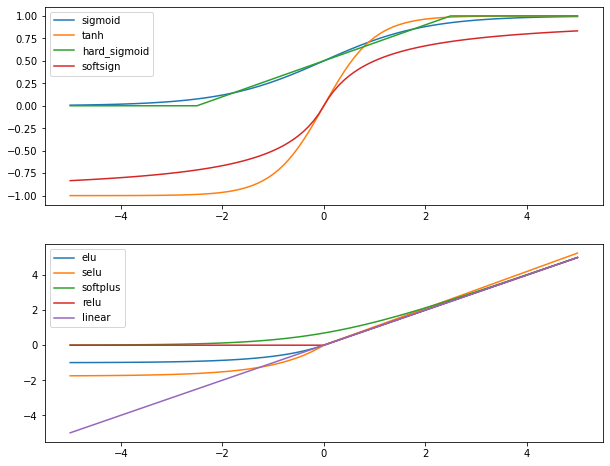

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-5, 5, 101).reshape(-1, 1)

# 絶対値の範囲が 有限なもの
activations_0 = [
    "sigmoid",
    "tanh",
    "hard_sigmoid",
    "softsign",
    ]

# 絶対値の範囲に上限がないもの
activations_1 = [
    "elu",
    "selu",
    "softplus",
    "relu",
    "linear",
]

fig = plt.figure(figsize=(10, 8))
for i, activations in enumerate([activations_0, activations_1]):
    ax = fig.add_subplot(2, 1,  i+1)
    for activation_str in activations:
        model = Sequential()
        model.add(
            Activation(
                activation_str,
                input_shape=(1, ),
            )
        )
        y = model.predict(x).ravel()
        ax.plot(x, y, label=activation_str)

    ax.legend()

plt.show()